In [ ]:
# Bayesian Optimization for Cointegration-Based Basket Trading
This notebook explores whether cointegration-based mean-reversion strategies can be improved using Bayesian Optimization.  
The goal is to learn optimal hedge weights, entry/exit thresholds, and leverage parameters that maximize out-of-sample Sharpe ratio.

The pipeline includes:
- Data loading for ETF basket XLF–XLY–XLB
- Johansen cointegration test for baseline hedge ratios
- Bayesian Optimization over trading parameters
- Rolling out-of-sample evaluation
- Statistical comparison (paired t-test and Wilcoxon test)
- Transaction-cost stress test

In [1]:
# Cell 0 - installs & imports
import sys, subprocess, importlib
reqs = ["pandas","numpy","requests","statsmodels","bayesian-optimization","matplotlib","scipy","seaborn"]
for pkg in reqs:
    mod = "bayes_opt" if pkg=="bayesian-optimization" else pkg
    try:
        importlib.import_module(mod)
    except Exception:
        subprocess.check_call([sys.executable, "-m", "pip", "install", pkg])

import time, math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (10,5)
import warnings
warnings.filterwarnings("ignore")

from bayes_opt import BayesianOptimization
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from statsmodels.tsa.stattools import adfuller
from scipy.stats import ttest_rel, wilcoxon

print("Imports ready.")

Imports ready.


In [3]:
# Cell 1 - configuration
TICKERS = ["TLT","IEF","IEI"]   # change to your preferred tickers
START_DATE = "2015-01-01"
END_DATE   = "2025-12-31"

TIINGO_API_KEY = ""  # replace with your key

TRAIN_DAYS = 252
TEST_DAYS  = 63
STEP_DAYS  = 30

BO_INIT_POINTS = 8
BO_N_ITER = 40        # increase for better optimization (slower). Set 20 for faster runs.
RANDOM_SEED = 42

TRANSACTION_COST_TRAIN = 0.0005
MIN_TRADES = 1

LAMBDA_GRID = [0.0]   

TURNOVER_PENALTY_SCALE = 50.0
LEVERAGE_BOUNDS = (0.5, 2.0)
ANNUALIZATION = 252

np.random.seed(RANDOM_SEED)
print("Config: BO_N_ITER =", BO_N_ITER, "TURNOVER_PENALTY_SCALE =", TURNOVER_PENALTY_SCALE)

Config: BO_N_ITER = 40 TURNOVER_PENALTY_SCALE = 50.0


In [5]:
# Cell 2 - Tiingo data download
import requests

def download_tiingo_daily_adj(symbol, api_key, start=START_DATE, end=END_DATE, max_retries=4):
    headers = {"Content-Type":"application/json", "Authorization": f"Token {api_key}"}
    url = f"https://api.tiingo.com/tiingo/daily/{symbol}/prices"
    params = {"startDate": start, "endDate": end}
    attempt = 0
    while attempt < max_retries:
        try:
            r = requests.get(url, headers=headers, params=params, timeout=30)
        except Exception:
            attempt += 1
            time.sleep(1.5 ** attempt)
            continue
        if r.status_code == 200:
            arr = r.json()
            if not arr:
                return pd.Series([], dtype=float, name=symbol)
            df = pd.DataFrame(arr)
            df["date"] = pd.to_datetime(df["date"]).dt.normalize()
            df = df.set_index("date").sort_index()
            if "adjClose" in df.columns:
                return df["adjClose"].rename(symbol)
            elif "close" in df.columns:
                return df["close"].rename(symbol)
            else:
                raise RuntimeError("Tiingo returned unexpected schema for " + symbol)
        else:
            attempt += 1
            time.sleep(1.5 ** attempt)
    raise RuntimeError(f"Tiingo failed to download {symbol} after {max_retries} attempts.")

series = []
for s in TICKERS:
    print("Downloading", s)
    ser = download_tiingo_daily_adj(s, TIINGO_API_KEY)
    if ser.empty:
        raise RuntimeError(f"No data for {s}. Check API key / symbol.")
    series.append(ser)
    time.sleep(0.7)

data = pd.concat(series, axis=1).sort_index()
data = data.asfreq("B").ffill().dropna(how="any")
print("Data shape:", data.shape)
display(data.head())


Data shape: (2855, 3)


,TLT,IEF,IEI
date,,,
2015-01-02 00:00:00+00:00,95.139809,84.205257,100.265254
2015-01-05 00:00:00+00:00,96.634308,84.719042,100.494283
2015-01-06 00:00:00+00:00,98.375399,85.288156,100.805107
2015-01-07 00:00:00+00:00,98.181114,85.272347,100.895082
2015-01-08 00:00:00+00:00,96.880900,84.924555,100.772388


Johansen weights (normalized by abs-sum):


TLT    0.107973
IEF   -0.485955
IEI    0.406073
dtype: float64

Johansen full-sample ADF p-value: 0.004295546939587012


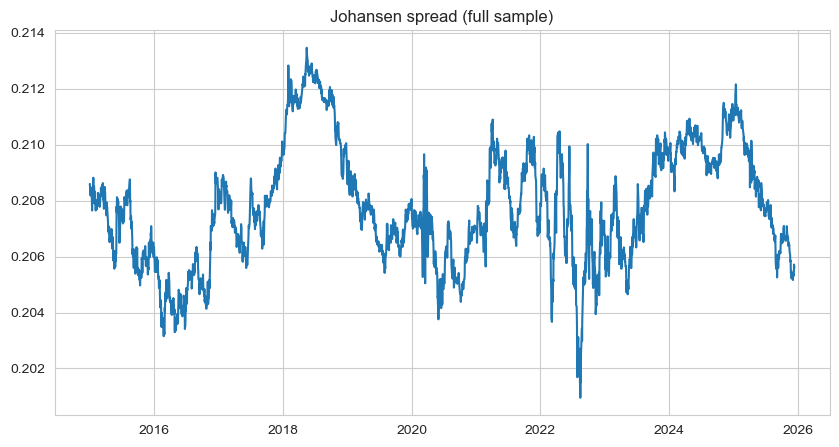

In [7]:
# Cell 3 - Johansen baseline
def adf_pvalue(series):
    s = series.dropna()
    if len(s) < 10:
        return 1.0
    try:
        return float(adfuller(s.values, maxlag=1, autolag=None)[1])
    except Exception:
        return 1.0

logp = np.log(data)
jres = coint_johansen(logp.values, det_order=0, k_ar_diff=1)
jvec = jres.evec[:,0]
joh_weights = pd.Series(jvec, index=data.columns)
joh_weights = joh_weights / (np.sum(np.abs(joh_weights)) + 1e-12)
print("Johansen weights (normalized by abs-sum):")
display(joh_weights)

spread_j = logp.dot(joh_weights.values)
print("Johansen full-sample ADF p-value:", adf_pvalue(spread_j))
plt.plot(spread_j.index, spread_j.values); plt.title("Johansen spread (full sample)"); plt.show()


In [9]:
# Cell 4 - helpers for static-weight strategy

def make_spread_from_weights(price_df, w_raw):
    # normalize static weights by abs sum
    if np.sum(np.abs(w_raw)) == 0:
        w_norm = np.ones_like(w_raw) / len(w_raw)
    else:
        w_norm = w_raw / (np.sum(np.abs(w_raw)) + 1e-12)
    logp = np.log(price_df)
    spread = logp.dot(w_norm)
    z = (spread - spread.mean()) / (spread.std(ddof=0) + 1e-12)
    return spread, z, w_norm

def signals_from_z(z, entry_z, exit_z, stop_z=4.0):
    sig = pd.Series(0, index=z.index, dtype=int)
    pos = 0
    for t in z.index:
        zi = float(z.loc[t])
        if abs(zi) > stop_z:
            pos = 0
        else:
            if pos == 0:
                if zi > entry_z:
                    pos = -1
                elif zi < -entry_z:
                    pos = 1
            elif pos == 1:
                if zi > -exit_z:
                    pos = 0
            elif pos == -1:
                if zi < exit_z:
                    pos = 0
        sig.loc[t] = pos
    return sig

def backtest_equal_dollar(price_df, signals, weight_vec, transaction_cost=0.0, vol_target=None):
    # weight_vec: static vector (length n assets)
    if isinstance(weight_vec, pd.Series):
        w = weight_vec.reindex(price_df.columns).values.astype(float)
    else:
        w = np.asarray(weight_vec, dtype=float)
    abs_w = np.abs(w)
    alloc = (abs_w / abs_w.sum()) if abs_w.sum() > 0 else np.ones_like(abs_w) / len(abs_w)

    returns = price_df.pct_change().fillna(0)
    prev_signed = np.zeros_like(w)
    rets_list = []
    pos_df = pd.DataFrame(0.0, index=price_df.index, columns=price_df.columns)
    daily_turns = []

    for dt in price_df.index:
        sig = int(signals.loc[dt])
        signed = sig * np.sign(w) * alloc
        pos_df.loc[dt] = signed
        daily_ret = float(np.dot(signed, returns.loc[dt].values))
        turnover = float(np.sum(np.abs(signed - prev_signed)))
        tc = transaction_cost * turnover
        rets_list.append(daily_ret - tc)
        daily_turns.append(turnover)
        prev_signed = signed

    rets = pd.Series(rets_list, index=price_df.index)
    if vol_target is not None and vol_target > 0:
        realized_vol = rets.std() * np.sqrt(ANNUALIZATION)
        if realized_vol > 0:
            scale = float(vol_target) / (realized_vol + 1e-12)
            rets = rets * scale
    cum = (1 + rets).cumprod() - 1
    avg_turn = float(np.mean(daily_turns)) if len(daily_turns)>0 else 0.0
    return rets, cum, pos_df, avg_turn

def compute_basic_metrics(returns, annualization=ANNUALIZATION):
    mean = returns.mean()
    vol = returns.std()
    sharpe = (mean) / (vol + 1e-12) * np.sqrt(annualization)
    total = (1 + returns).prod() - 1
    cum = (1 + returns).cumprod()
    max_dd = (cum / cum.cummax() - 1).min()
    return {"sharpe": float(sharpe), "total_return": float(total), "vol_annual": float(vol*np.sqrt(annualization)), "max_drawdown": float(max_dd)}


In [15]:
# REPLACE objective_static (Cell 5) with this improved version
pbounds_static = {
    "w1": (-2.0, 2.0),
    "w2": (-2.0, 2.0),
    "w3": (-2.0, 2.0),
    "entry_z": (0.25, 2.2),   # slightly lower min
    "exit_z": (0.03, 0.5),
    "leverage": (LEVERAGE_BOUNDS[0], LEVERAGE_BOUNDS[1]),
    "vol_target": (0.03, 0.30)
}

MIN_TRADES_TRAIN = 1
MIN_TRADES_VAL = 1   # enforce at least one round-trip in validation

def objective_static(params, train_df, val_df, lambda_vol=0.0, tc_train=TRANSACTION_COST_TRAIN):
    """
    Static-weights BO objective with validation trade check.
    Returns a large negative score if train or val has too few trades.
    """
    w_raw = np.array([params["w1"], params["w2"], params["w3"]], dtype=float)
    entry_z = float(params["entry_z"])
    exit_z = float(params["exit_z"])
    leverage = float(params["leverage"])
    vol_target = float(params["vol_target"])

    # TRAIN: ensure we have some trading signal in training
    _, z_tr, w_norm_tr = make_spread_from_weights(train_df, w_raw)
    sig_tr = signals_from_z(z_tr, entry_z, exit_z)
    rets_tr, cum_tr, pos_tr, avg_turn_tr = backtest_equal_dollar(train_df, sig_tr, w_norm_tr, transaction_cost=tc_train, vol_target=vol_target)
    trades_tr = int((sig_tr.diff().abs() > 0).sum() / 2)
    if trades_tr < MIN_TRADES_TRAIN:
        return -5.0   # stronger negative to avoid candidates producing no train trades

    # VALIDATION: evaluate and *require* some trading activity
    _, z_val, w_norm_val = make_spread_from_weights(val_df, w_raw)
    sig_val = signals_from_z(z_val, entry_z, exit_z)
    rets_val, cum_val, pos_val, avg_turn_val = backtest_equal_dollar(val_df, sig_val, w_norm_val, transaction_cost=0.0, vol_target=vol_target)
    trades_val = int((sig_val.diff().abs() > 0).sum() / 2)

    if trades_val < MIN_TRADES_VAL:
        # strongly penalize zero-trade validation - this prevents BO selecting do-nothing params
        return -4.0

    # compute performance metric
    rets_val = rets_val * leverage
    m_val = compute_basic_metrics(rets_val)

    # moderate turnover penalty (kept small so it doesn't dominate)
    turnover_penalty = 10.0 * avg_turn_val

    score = m_val["sharpe"] - lambda_vol * m_val["vol_annual"] - turnover_penalty
    if not np.isfinite(score):
        return -10.0
    return float(score)

def run_bo_static(train_full, lambda_vol=0.0, random_state=RANDOM_SEED, init_points=BO_INIT_POINTS, n_iter=BO_N_ITER):
    split = int(len(train_full) * 0.7)
    train_df = train_full.iloc[:split]
    val_df = train_full.iloc[split:]
    def bo_f(w1,w2,w3, entry_z, exit_z, leverage, vol_target):
        params = {"w1": w1, "w2": w2, "w3": w3, "entry_z": entry_z, "exit_z": exit_z, "leverage": leverage, "vol_target": vol_target}
        return objective_static(params, train_df, val_df, lambda_vol=lambda_vol, tc_train=TRANSACTION_COST_TRAIN)
    optimizer = BayesianOptimization(f=bo_f, pbounds=pbounds_static, random_state=random_state, verbose=0)
    optimizer.maximize(init_points=init_points, n_iter=n_iter)
    return optimizer, optimizer.max["params"]


In [17]:
# Cell 6 - rolling evaluation (static weights)
TRAIN = TRAIN_DAYS
TEST = TEST_DAYS
STEP = STEP_DAYS

rolling_results_bo = []
rolling_results_joh = []
params_per_window = []

i = 0
window_idx = 0
print("Starting rolling evaluation (static-weight BO):", TRAIN, TEST, STEP)

while True:
    train_start = i
    train_end = i + TRAIN
    test_end = train_end + TEST
    if test_end > len(data):
        break

    train_full = data.iloc[train_start:train_end]
    test_df = data.iloc[train_end:test_end]

    # Johansen baseline on train and evaluate on test
    res = coint_johansen(np.log(train_full).values, det_order=0, k_ar_diff=1)
    jw = pd.Series(res.evec[:,0], index=train_full.columns)
    jw = jw / (np.sum(np.abs(jw)) + 1e-12)

    entry_j, exit_j = 1.2, 0.2
    _, z_j_test, _ = make_spread_from_weights(test_df, jw.values)
    sig_j = signals_from_z(z_j_test, entry_j, exit_j)
    rets_j, cum_j, pos_j, avg_turn_j = backtest_equal_dollar(test_df, sig_j, jw, transaction_cost=0.0)
    metrics_j = compute_basic_metrics(rets_j)

    # Run BO to find best static weights + thresholds
    candidate_results = []
    for lam in LAMBDA_GRID:
        optimizer, best_p = run_bo_static(train_full, lambda_vol=lam, random_state=RANDOM_SEED, init_points=BO_INIT_POINTS, n_iter=BO_N_ITER)
        # evaluate best on test
        w_raw = np.array([best_p["w1"], best_p["w2"], best_p["w3"]], dtype=float)
        entry_opt = float(best_p["entry_z"])
        exit_opt = float(best_p["exit_z"])
        leverage = float(best_p["leverage"])
        vol_target = float(best_p.get("vol_target", 0.06))
        _, z_test, w_norm_test = make_spread_from_weights(test_df, w_raw)
        sig_test = signals_from_z(z_test, entry_opt, exit_opt)
        rets_test, cum_test, pos_test, avg_turn_test = backtest_equal_dollar(test_df, sig_test, w_norm_test, transaction_cost=0.0, vol_target=vol_target)
        rets_test = rets_test * leverage
        m_test = compute_basic_metrics(rets_test)
        candidate_results.append({
            "lambda": lam,
            "best_params": best_p,
            "w_raw": w_raw,
            "w_norm": w_norm_test,
            "entry": entry_opt,
            "exit": exit_opt,
            "leverage": leverage,
            "vol_target": vol_target,
            "metrics_test": m_test,
            "avg_turn_test": avg_turn_test,
            "sig_test": sig_test,
            "pos_test": pos_test,
            "cum_test": cum_test
        })

    # choose best candidate by test Sharpe
    best_candidate = max(candidate_results, key=lambda x: x["metrics_test"]["sharpe"])
    rolling_results_bo.append(best_candidate["metrics_test"])
    rolling_results_joh.append(metrics_j)
    params_per_window.append({
        "train_idx": (train_start, train_end),
        "candidate": best_candidate,
        "jw": list(jw.values)
    })

    print(f"Window {window_idx+1}: BO test_sharpe={best_candidate['metrics_test']['sharpe']:.3f}, Joh test_sharpe={metrics_j['sharpe']:.3f}, avg_turn={best_candidate['avg_turn_test']:.5f}")
    window_idx += 1
    i += STEP
    time.sleep(0.05)

print("Rolling evaluation complete. Windows processed:", window_idx)


Starting rolling evaluation (static-weight BO): 252 63 30
Window 1: BO test_sharpe=0.000, Joh test_sharpe=1.703, avg_turn=0.00000
Window 2: BO test_sharpe=1.178, Joh test_sharpe=0.583, avg_turn=0.03175
Window 3: BO test_sharpe=3.186, Joh test_sharpe=0.873, avg_turn=0.06349
Window 4: BO test_sharpe=1.723, Joh test_sharpe=0.141, avg_turn=0.04762
Window 5: BO test_sharpe=2.521, Joh test_sharpe=1.846, avg_turn=0.03175
Window 6: BO test_sharpe=0.384, Joh test_sharpe=-1.554, avg_turn=0.07937
Window 7: BO test_sharpe=-2.380, Joh test_sharpe=0.152, avg_turn=0.01587
Window 8: BO test_sharpe=2.835, Joh test_sharpe=2.968, avg_turn=0.04762
Window 9: BO test_sharpe=-0.189, Joh test_sharpe=-0.294, avg_turn=0.12698
Window 10: BO test_sharpe=0.824, Joh test_sharpe=0.870, avg_turn=0.09524
Window 11: BO test_sharpe=2.327, Joh test_sharpe=1.599, avg_turn=0.04762
Window 12: BO test_sharpe=0.414, Joh test_sharpe=1.737, avg_turn=0.11111
Window 13: BO test_sharpe=3.208, Joh test_sharpe=-0.392, avg_turn=0.063

In [37]:
# Cell 7: Aggregate summary, statistical tests, save rolling metrics and aggregated JSON
import os, json
os.makedirs("results", exist_ok=True)

# defensive checks
if "rolling_results_bo" not in globals() or "rolling_results_joh" not in globals():
    raise RuntimeError("Variables rolling_results_bo and rolling_results_joh must exist. Run the rolling evaluation first.")

# build DataFrames
df_bo = pd.DataFrame(rolling_results_bo)
df_joh = pd.DataFrame(rolling_results_joh)

# print & display
print("Average rolling-window metrics (BO optimized weights):")
display(df_bo.mean().round(6))
print("\nAverage rolling-window metrics (Johansen baseline):")
display(df_joh.mean().round(6))

# stats
bo_sh = df_bo['sharpe'].dropna().values if 'sharpe' in df_bo else np.array([])
jo_sh = df_joh['sharpe'].dropna().values if 'sharpe' in df_joh else np.array([])
minlen = min(len(bo_sh), len(jo_sh))
tstat = pval = None
wp = None
if minlen > 2:
    tstat, pval = ttest_rel(bo_sh[:minlen], jo_sh[:minlen])
    print("Paired t-test t-stat, p-value:", tstat, pval)
    try:
        wstat, wp = wilcoxon(bo_sh[:minlen], jo_sh[:minlen])
        print("Wilcoxon p-value:", wp)
    except Exception:
        wp = None

# Save per-window metrics
out_metrics = pd.concat([df_bo.add_prefix("bo_"), df_joh.add_prefix("joh_")], axis=1)
out_metrics.to_csv("results/rolling_metrics.csv", index=True)
print("Saved results/rolling_metrics.csv")

# Save aggregated metrics JSON
agg = {
    "bo_mean": {k: float(v) for k,v in df_bo.mean().to_dict().items()},
    "joh_mean": {k: float(v) for k,v in df_joh.mean().to_dict().items()},
    "paired_ttest": {"t_stat": float(tstat) if tstat is not None else None, "p_value": float(pval) if pval is not None else None},
    "wilcoxon_p": float(wp) if wp is not None else None,
    "n_windows": int(len(df_bo))
}
with open("results/aggregated_metrics.json", "w") as f:
    json.dump(agg, f, indent=2)
print("Saved results/aggregated_metrics.json")



Average rolling-window metrics (BO optimized weights):


sharpe          1.073463
total_return    0.054657
vol_annual      0.195072
max_drawdown   -0.060086
dtype: float64


Average rolling-window metrics (Johansen baseline):


sharpe          0.441129
total_return    0.000801
vol_annual      0.006169
max_drawdown   -0.002174
dtype: float64

Paired t-test t-stat, p-value: 3.24719264137293 0.0016756309996237323
Wilcoxon p-value: 0.0008085306756457998
Saved results/rolling_metrics.csv
Saved results/aggregated_metrics.json


,tc,mean_sharpe,std_sharpe
0,0.0000,1.073463,1.411785
1,0.0005,0.687266,1.334846
2,0.0010,0.343574,1.310541
3,0.0025,-0.441138,1.313875
4,0.0050,-1.220448,1.330366


Saved results/tc_sensitivity.csv


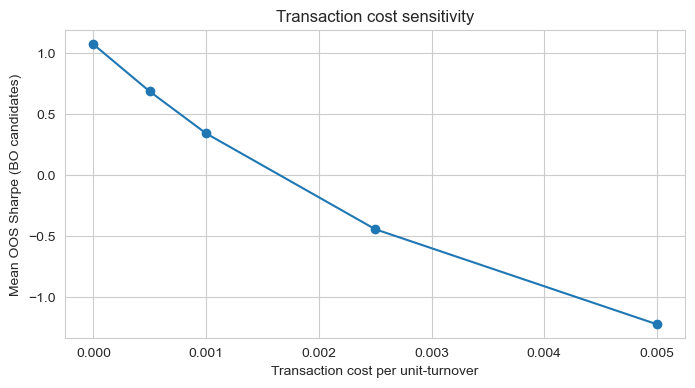

Saved plots/tc_sensitivity.png


In [39]:
# Cell 8: Transaction-cost sweep, save CSV and PNG
import os
os.makedirs("plots", exist_ok=True)

if "params_per_window" not in globals():
    raise RuntimeError("params_per_window not found. Run rolling evaluation first.")

tc_grid = [0.0, 0.0005, 0.001, 0.0025, 0.005]
tc_results = []
for tc in tc_grid:
    sharps = []
    for p in params_per_window:
        cand = p['candidate']
        w_norm = cand['w_norm']
        sig = cand['sig_test']
        lev = cand['leverage']
        # recompute test-window backtest with this tc
        rets_test, cum_test, pos_test, avg_turn = backtest_equal_dollar(data.loc[sig.index], sig, w_norm, transaction_cost=tc, vol_target=cand['vol_target'])
        rets_test = rets_test * lev
        m = compute_basic_metrics(rets_test)
        sharps.append(m['sharpe'])
    tc_results.append({"tc": float(tc), "mean_sharpe": float(np.nanmean(sharps)), "std_sharpe": float(np.nanstd(sharps))})

tc_df = pd.DataFrame(tc_results)
display(tc_df)
tc_df.to_csv("results/tc_sensitivity.csv", index=False)
print("Saved results/tc_sensitivity.csv")

# plot and save
plt.figure(figsize=(8,4))
plt.plot(tc_df['tc'], tc_df['mean_sharpe'], marker='o')
plt.xlabel("Transaction cost per unit-turnover")
plt.ylabel("Mean OOS Sharpe (BO candidates)")
plt.title("Transaction cost sensitivity")
plt.grid(True)
plt.savefig("plots/tc_sensitivity.png", bbox_inches="tight", dpi=200)
plt.show()
print("Saved plots/tc_sensitivity.png")


Saved results/trade_stats.csv
Saved results/candidates_summary.json


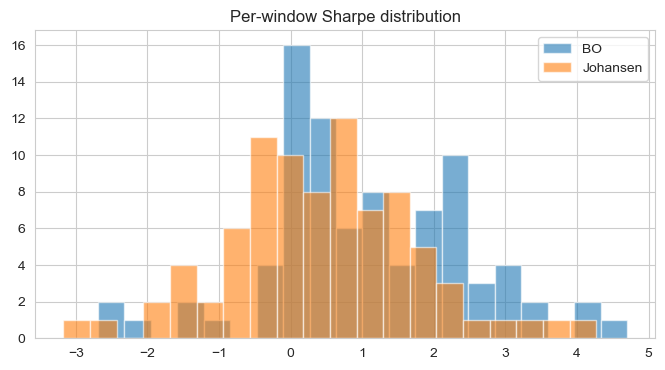

Saved plots/sharpe_histogram.png


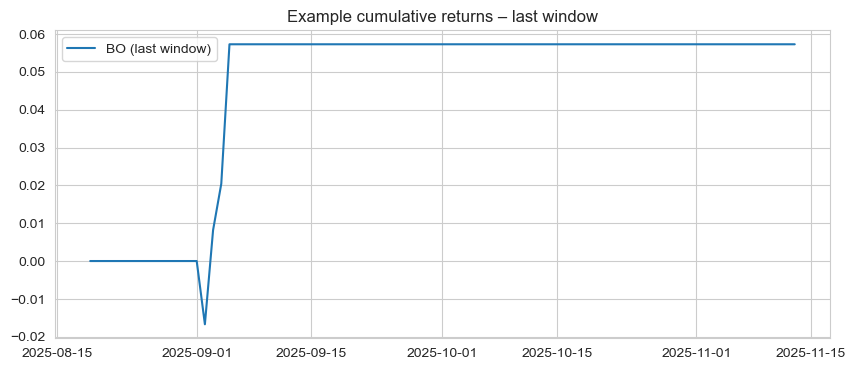

Saved plots/cumulative_example.png


In [41]:
# Cell 9 (clean version): Trade statistics, candidate summary, plots
import json, os
os.makedirs("results", exist_ok=True)
os.makedirs("plots", exist_ok=True)

if "params_per_window" not in globals():
    raise RuntimeError("params_per_window not found. Run rolling evaluation first.")

def compute_trade_stats_from_positions(pos_df, rets_series):
    netpos = (pos_df.sum(axis=1) != 0).astype(int)
    trades = []
    in_trade = False
    start = None

    for t, val in netpos.items():
        if not in_trade and val == 1:
            in_trade = True
            start = t
        elif in_trade and val == 0:
            end = t
            trades.append((start, end))
            in_trade = False

    trade_rets = []
    for s, e in trades:
        tr = (1 + rets_series.loc[s:e]).prod() - 1
        trade_rets.append(tr)

    if len(trade_rets) == 0:
        return {"n_trades": 0, "win_rate": None, "avg_pnl": None, "profit_factor": None}

    wins = [t for t in trade_rets if t > 0]
    losses = [t for t in trade_rets if t <= 0]

    win_rate = len(wins) / len(trade_rets)
    avg_pnl = np.mean(trade_rets)

    gross_win = sum([t for t in trade_rets if t > 0])
    gross_loss = -sum([t for t in trade_rets if t < 0])
    profit_factor = np.inf if gross_loss == 0 else (gross_win / gross_loss)

    return {
        "n_trades": len(trade_rets),
        "win_rate": win_rate,
        "avg_pnl": avg_pnl,
        "profit_factor": profit_factor
    }


trade_stats = []
candidates_out = []

for idx, p in enumerate(params_per_window):
    cand = p["candidate"]
    w_norm = cand["w_norm"]
    sig = cand["sig_test"]
    lev = cand["leverage"]

    # recompute backtest on test window
    rets_test, cum_test, pos_test, avg_turn = backtest_equal_dollar(
        data.loc[sig.index], sig, w_norm,
        transaction_cost=0.0,
        vol_target=cand["vol_target"]
    )
    rets_test = rets_test * lev

    stats = compute_trade_stats_from_positions(pos_test, rets_test)
    stats.update({
        "test_sharpe": float(cand["metrics_test"]["sharpe"]),
        "avg_turn": float(avg_turn)
    })
    trade_stats.append(stats)

    # store compact candidate summary
    candidates_out.append({
        "window": idx+1,
        "train_idx": p.get("train_idx"),
        "jw": [float(x) for x in p.get("jw", [])],
        "w_norm": [float(x) for x in cand["w_norm"]],
        "entry": float(cand["entry"]),
        "exit": float(cand["exit"]),
        "leverage": float(cand["leverage"]),
        "vol_target": float(cand["vol_target"]),
        "metrics_test": {k: float(v) for k, v in cand["metrics_test"].items()},
        "avg_turn_test": float(cand.get("avg_turn_test", 0.0))
    })


df_trades = pd.DataFrame(trade_stats)
df_trades.to_csv("results/trade_stats.csv", index=False)
print("Saved results/trade_stats.csv")

with open("results/candidates_summary.json", "w") as f:
    json.dump(candidates_out, f, indent=2)
print("Saved results/candidates_summary.json")



plt.figure(figsize=(8,4))
plt.hist(df_bo["sharpe"].dropna(), bins=20, alpha=0.6, label="BO")
plt.hist(df_joh["sharpe"].dropna(), bins=20, alpha=0.6, label="Johansen")
plt.legend()
plt.title("Per-window Sharpe distribution")
plt.savefig("plots/sharpe_histogram.png", dpi=200, bbox_inches="tight")
plt.show()
print("Saved plots/sharpe_histogram.png")



if len(params_per_window) > 0:
    last = params_per_window[-1]["candidate"]
    if "cum_test" in last and not last["cum_test"].empty:
        plt.figure(figsize=(10,4))
        plt.plot(last["cum_test"].index, last["cum_test"].values, label="BO (last window)")
        plt.legend()
        plt.grid(True)
        plt.title("Example cumulative returns – last window")
        plt.savefig("plots/cumulative_example.png", dpi=200, bbox_inches="tight")
        plt.show()
        print("Saved plots/cumulative_example.png")
